# Dogs vs Cats

https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

In [1]:
import cv2
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.applications import vgg16


## Функции загрузки данных

In [2]:
import os
from random import shuffle
from glob import glob

IMG_SIZE = (224, 224)  # задаем размер изображения

train_files = glob('/content/drive/MyDrive/Colab Notebooks/Data/train/*.jpg')
test_files = glob('/content/drive/MyDrive/Colab Notebooks/Data/test/*.jpg')

# предобработка изображения
def load_image(path, target_size=IMG_SIZE):
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, target_size)
    return vgg16.preprocess_input(img)  

# загрузка трейновых изображений
def fit_generator(files, batch_size=32):
    batch_size = min(batch_size, len(files))
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if os.path.basename(path).startswith('dog') else 0.
                          for path in files[i:j]])
            yield (x, y)

# загрузка тестовых изображений
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])
#вывод потерь
def loss_plot(m):
    plt.plot(m.history['loss'], label='train loss')
    plt.plot(m.history['val_loss'], label='val_loss')
    plt.legend()
    plt.show()

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Посмотрим обучающие примеры

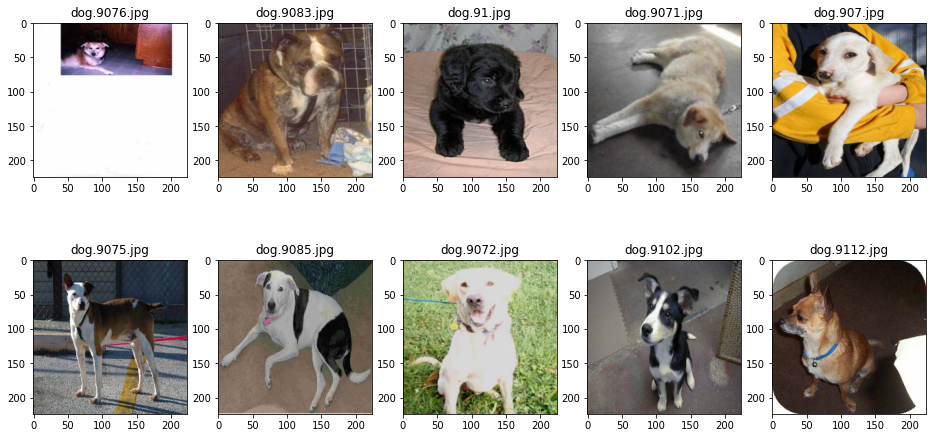

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(16, 8))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%s' % path.split('/')[-1])
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    plt.imshow(img)

## Возьмем предобученную модель

In [5]:
# base_model - объект класса keras.models.Model (Functional Model)
base_model = vgg16.VGG16(weights='imagenet',
                         include_top=False,
                         input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

In [6]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     



## Добавим BatchNormalization и один полносвязный слой.

In [7]:
# фиксируем все веса предобученной сети
for layer in base_model.layers:
    layer.trainable = False

x = base_model.layers[-1].output
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1,  # один выход (бинарная классификация)
                          activation='sigmoid',  # функция активации
                          )(x)

model = tf.keras.Model(inputs=base_model.input, outputs=x, name='dogs_vs_cats')

## Проверим архитектуру модели

In [8]:
model.summary()

Model: "dogs_vs_cats"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

## Скомпилируем модель и стартанём обучение

In [9]:
model.compile(optimizer='sgd', 
              loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss
              metrics=['accuracy'])

In [10]:
val_samples = 5  # число изображений в валидационной выборке

shuffle(train_files)  # перемешиваем обучающую выборку
validation_data = next(fit_generator(train_files[:val_samples], val_samples))
train_data = fit_generator(train_files[val_samples:])  # данные читаем функцией-генератором

# запускаем процесс обучения
m = model.fit(train_data,
          steps_per_epoch=10,  # число вызовов генератора за эпоху
          epochs=100,  # число эпох обучения
          validation_data=validation_data)

Epoch 1/100
10/10 [==============================] - 50s 5s/step - loss: 0.4131 - accuracy: 0.7929 - val_loss: 8.5817e-05 - val_accuracy: 1.0000
Epoch 2/100
10/10 [==============================] - 46s 5s/step - loss: 0.1278 - accuracy: 0.9497 - val_loss: 2.1587e-04 - val_accuracy: 1.0000
Epoch 3/100
10/10 [==============================] - 49s 5s/step - loss: 0.0937 - accuracy: 0.9493 - val_loss: 9.3253e-04 - val_accuracy: 1.0000
Epoch 4/100
10/10 [==============================] - 50s 5s/step - loss: 0.1013 - accuracy: 0.9579 - val_loss: 6.8046e-04 - val_accuracy: 1.0000
Epoch 5/100
10/10 [==============================] - 50s 5s/step - loss: 0.0925 - accuracy: 0.9627 - val_loss: 8.6414e-04 - val_accuracy: 1.0000
Epoch 6/100
10/10 [==============================] - 111s 12s/step - loss: 0.0884 - accuracy: 0.9701 - val_loss: 3.9372e-04 - val_accuracy: 1.0000
Epoch 7/100
10/10 [==============================] - 47s 5s/step - loss: 0.1553 - accuracy: 0.9571 - val_loss: 7.0469e-04 - val_

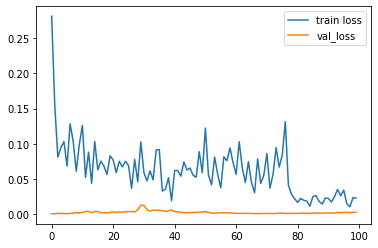

In [11]:
loss_plot(m)


## Сохранием модель

In [12]:
model.save('/content/drive/MyDrive/Colab Notebooks/Data/cats_dogs_v3.hdf5')

## Отработаем на проверочной выборке

In [13]:
test_pred = model.predict(predict_generator(test_files), steps=len(test_files))

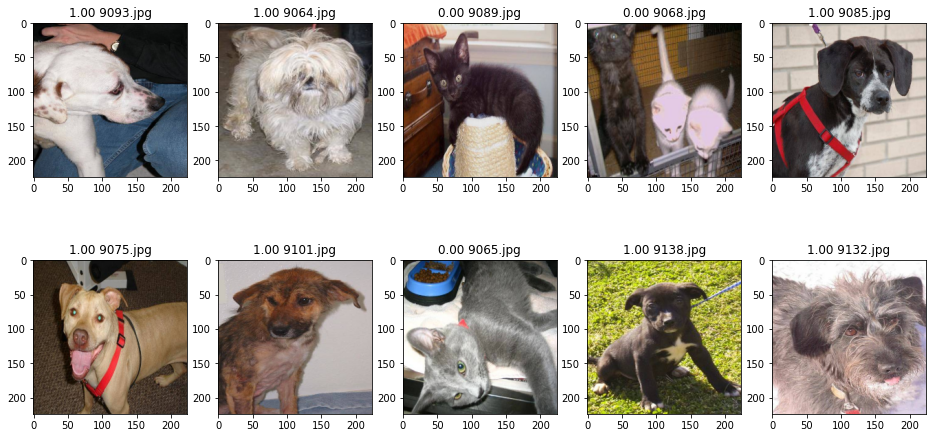

In [14]:
fig = plt.figure(figsize=(16, 8))
for i, (path, score) in enumerate(zip(test_files[:10], test_pred[:10]), 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%.2f %s' % (score, os.path.basename(path)))
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    subplot.imshow(img)

## Сделаем результаты для отправки

In [15]:
import re

with open('/content/drive/MyDrive/Colab Notebooks/Data/KAV_submition.csv', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, test_pred):
        dst.write('%s,%f\n' % (re.search('(\d+).jpg$', path).group(1), score))

## Посмотрим результат оценки работы модели на test-выборке на Kaggle.

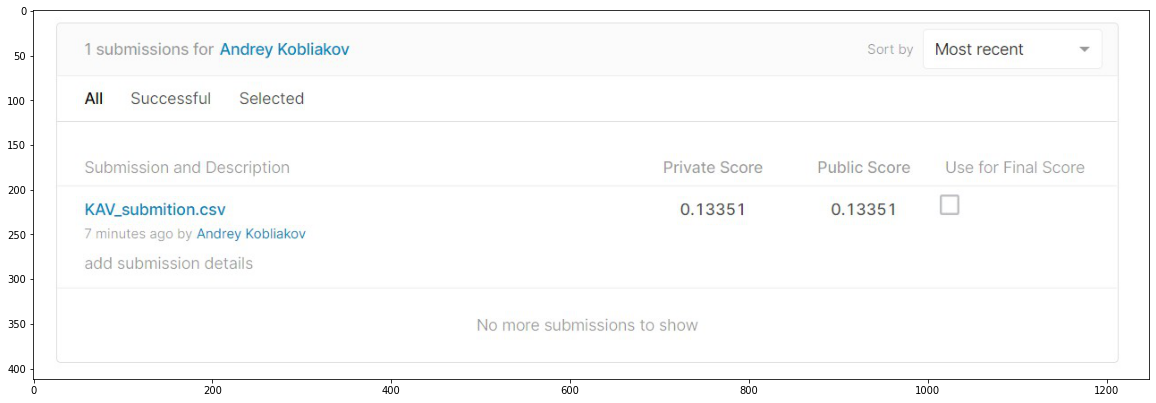

In [26]:
from skimage import io
img_cv = io.imread('/content/drive/MyDrive/Colab Notebooks/Data/Kav_submission.jpg')
img_rgb = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20, 10))
plt.imshow(img_cv)